# Práctica de reconstrucción.  Parte I. Calibración de cámaras

Visión Computacional 2018-19 <br>
Practica 2. 29 de octubre de 2018

Este enunciado está en el archivo "PracticaCalib2018.ipynb" o su versión "pdf" que puedes encontrar en el Aula Virtual.

## Objetivos


Los objetivos de esta práctica son:
* Calibrar una cámara usando el método de calibración de Zhang, que está implementado en OpenCV.
* Hacer uso de los resultados de la calibración en un sistema simple de realidad aumentada que proyecte un modelo 3D sintético sobre imágenes reales. Esta parte es opcional.
* Calibrar un par de cámaras y deducir información sobre la posición relativa de las mismas.

## Requerimientos

Para esta práctica es necesario disponer del siguiente software:
* Python 2.7 ó 3.X 
* Jupyter http://jupyter.org/.
* Las librerías científicas de Python: NumPy, SciPy, y Matplotlib.
* La librería OpenCV.

El material necesario para la práctica se puede descargar del Aula Virtual en la carpeta ``MaterialesPractica``. Esta
carpeta contiene:
* El enunciado de esta práctica.
* Dos secuencias de imágenes tomadas con un par de cámaras (izquierda y derecha) en los directorios ``left`` y ``right``.
* Tres modelos tridimensionales: la tetera de Utah (teapot), el conejo de Stanford (bunny) y un cubo (cube).   
  La carga de un modelo en Python se realiza como si fuera un módulo. Por ejemplo: ``from models import bunny``.
El módulo cargado contiene dos variables:
  - ``bunny.vertices`` es una matriz $4 × N_v$ con las coordenadas homogéneas de los $N_v$ vértices del modelo (en este caso, el conejo de Stanford). Cada columna son las coordenadas de un vértice.
  - bunny.edges es una matriz 2×N e con los N e arcos del modelo. Cada columna contiene los índices de los dos vértices que une un arco.

## Condiciones

* La fecha límite de entrega será el martes 20 de noviembre a las 23:55.
* La entrega consiste en dos archivos con el código, resultados y respuestas a los ejercicios:
  1. Un "notebook" de Jupyter con los resultados. Las respuestas a los ejercicios debes introducirlas en tantas celdas de código o texto como creas necesarias, insertadas inmediatamente después de  un enuciado y antes del siguiente.
  2. Un documento "pdf" generado a partir del fuente de Jupyter, por ejemplo usando el comando ``jupyter nbconvert --execute --to pdf notebook.ipynb``, o simplemente imprimiendo el "notebook" desde el navegador en la opción del menú "File->Print preview". Asegúrate de que el documento "pdf" contiene todos los resultados correctamente ejecutados.
* Esta práctica puede realizarse en parejas.

## 1. Calibración de una cámara

En esta parte se trabajará con la secuencia de imágenes del directorio ``left``. Esta secuencia contiene una serie de imágenes de la plantilla de calibración. Para la calibración se debe tener en cuenta que el tamaño de cada escaque de la plantilla es de 30 mm en las direcciones X e Y.

In [1]:
import cv2
import glob
import copy
import math
import numpy as np
import scipy.misc as scpm
import matplotlib.pyplot as plt

from pprint import pprint as pp

Implementa la función ``load_images(filenames)`` que reciba una lista de nombres de archivos de imagen
y las cargue como matrices de NumPy. Usa la función ``scipy.misc.imread`` para cargar las imágenes. La función
debe devolver una lista de matrices de NumPy con las imágenes leídas.

In [2]:
def load_images(filenames):
    return [scpm.imread(filename) for filename in filenames]

Usa ``load_images`` para cargar todas las imágenes del directorio ``left`` por orden alfabético (la función ``glob.glob`` permite generar la lista de nombres de archivo, y, por ejemplo, la función ``sorted()`` de Python ordena alfabéticamente una lista de cadenas de texto).

In [3]:
filenames = list(sorted(glob.glob("left/*.jpg")))
imgs = load_images(filenames)

/home/vision/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


La función ``cv2.findChessboardCorners`` de
OpenCV busca la plantilla de calibración en una imagen y
devuelve una tupla de dos elementos. El primer elemento
es 0 si no consiguió detectar correctamente la plantilla, y
es 1 en caso contrario. El segundo elemento contiene las
coordenadas de las esquinas de la plantilla de calibración,
que sólo son válidas si la detección fue exitosa, es decir, si
el primer elemento de la tupla es 1.

**Ejercicio 1.** Usa la  función ``cv2.findChessboardCorners``, y opcionalmente ``cv2.cornerSubPix``, para detectar automáticamente el patrón de calibración y sus esquinas en todas las imágenes cargadas. El tamaño de la plantilla de calibración en las imágenes
de la práctica es (8, 6) , esto es, 8 filas y 6 columnas. Almacena los resultados de las múltiples llamadas en
una lista, de modo que el elemento i de dicha lista corresponda al resultado de ``cv2.findChessboardCorners``
para la imagen i cargada anteriormente.


In [4]:
# Para cada imagen ejecutamos findChessboardCorners para encontrar las esquinas
corners = [cv2.findChessboardCorners(i, (8,6)) for i in imgs]

In [5]:
# OPTIONAL => cornerSubPix es destructivo. así que los copiamos a una nueva lista para no perder nada
corners2 = copy.deepcopy(corners)

# termination criteria (https://docs.opencv.org/3.1.0/dc/dbb/tutorial_py_calibration.html)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# Cada una de las imagenes la volvemos a blanco y negro
imgs_grey = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in imgs]
# Para cada imagen y esquina refinamos las esquinas con cornerSubPix
cornersRefined = [cv2.cornerSubPix(i, cor[1], (8, 6), (-1, -1), criteria) for i, cor in zip(imgs_grey, corners2)]
# pp(cornersRefined)

El siguiente ejercicio consiste en dibujar sobre las imágenes los puntos detectados por ``cv.FindChessboardCorners``. Por motivos de eficiencia, la función empleada para hacerlo modifica directamente las imagen pasadas por parámetro en lugar de hacer una copia. Para evitar perder las imágenes originales es mejor realizar una copia de las mismas con antelación. Una forma de hacerlo es ``imgs2 = copy.deepcopy(imgs)``
donde ``imgs`` es la lista de imágenes cargadas. Utiliza estas imágenes copiadas en lugar de las
originales en el siguiente ejercicio.

**Ejercicio 2.** Usa ``cv2.drawChessboardCorners`` para dibujar las esquinas detectadas en el ejercicio anterior. Aplícalo a todas las imágenes que fueron correctamente detectadas. Ignora el resto.
Muestra alguna de las imágenes resultantes.

In [6]:
# OPTIONAL => drawChessboardCorners es destructivo. así que copiamos a una nueva lista las imagenes para no perder nada
imgs2 = copy.deepcopy(imgs)

# Para cada imagen y esquina previamente calculada hacemos drawChessboardCorners si hemos encontrado la esquina
tmp = [cv2.drawChessboardCorners(img, (8,6), cor[1], cor[0]) for img, cor in zip(imgs2, corners) if cor[0]]

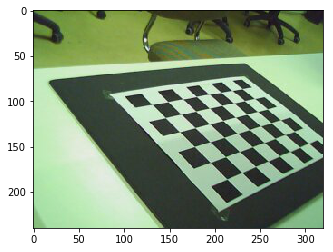

In [7]:
# Imagen original
plt.figure()
plt.imshow(imgs2[0])

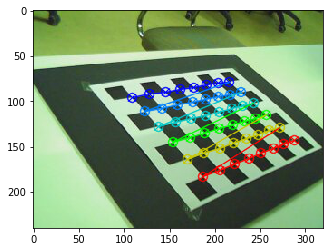

In [8]:
# Imagen con las esquinas dibujadas
plt.figure()
plt.imshow(imgs2[1])

Para calibrar la cámara, además de las coordenadas de
las esquinas en cada una de las imágenes, se necesitan las
coordenadas tridimensionales de las esquinas en el sistema
de referencia de la escena. Para esta práctica consideraremos que el centro del sistema de referencia, esto es, el
punto de coordenadas $[0, 0, 0]^\top$, es la primera esquina de
la plantilla de calibración detectada en todas las imágenes.
También consideraremos que el eje X corresponde al lado
corto de la plantilla de calibración, y el eje Y al lado largo.
Esta disposición implica que el eje Z apunta en la dirección
normal hacia arriba del plano de calibración.

Para el siguiente ejercicio es muy importante tener en
cuenta que las coordenadas de las esquinas en el sistema de
referencia de la escena deben darse en el mismo orden que
en el que fueron detectadas en cada una de las imágenes.

**Ejercicio 3.** Implementa la función ``get_chessboard_points(chessboard_shape, dx, dy)`` que genere una matriz de NumPy (es decir, un ndarray) de
tamaño $N × 3$ con las coordenadas $(x,y,z)$ de las esquinas de
la plantilla de calibración en el sistema de referencia de la
escena. $N$ es el número de esquinas de la plantilla.

``chessboard_shape`` es el número de puntos por filas
y por columnas de la plantilla de calibración. Al igual que
en el Ejercicio 1, debe ser (8, 6). ``dx`` (resp. ``dy``) es el ancho
(resp. alto) de un escaque de la plantilla de calibración.
Para la plantilla utilizada en esta práctica, ambos valores
son 30mm.

In [9]:
def get_chessboard_points(chessboard_shape, dx, dy):
    return [[(i%chessboard_shape[0])*dx, (i//chessboard_shape[0])*dy, 0] for i in range(np.prod(chessboard_shape))]

cb_points = get_chessboard_points((8, 6), 30, 30)
# pp(cb_points)

**Ejercicio 4.** Calibra la cámara izquierda usando la lista de resultados de ``cv2.findChessboardCorners``
y el conjunto de puntos del modelo dados por ``get_chessboard_points``, del ejercicio anterior.

Para ello usa la función calibrate que se distribuye con el material de la práctica.
Guarda el resultado de la calibración, matriz de intrínsecos y matrices de extrínsecos, con el comando
np.savez(‘calib_left’, intrinsic=intrinsic, extrinsic=extrinsic)

In [10]:
# Para cada una de las esquinas sacamos las que el metodo ha encontrado (cor[0] verdadero)
valid_corners = [cor[1] for cor in corners if cor[0]]

num_valid_images = len(valid_corners)

# Matriz 30x3 con las coordenadas de los puntos de las esquinas
real_points = get_chessboard_points((8, 6), 30, 30)

# Convertimos nuestra lista de puntos en el sistema de referencia de la escena en un array
object_points = np.asarray([real_points for i in range(num_valid_images)], dtype=np.float32)

# Convertimos nuestra lista de esquinas calculadas en un array
image_points = np.asarray(valid_corners, dtype=np.float32)

# Calibramos
rms, intrinsics, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(object_points, image_points, imgs[1].shape[0:2], None, None)
# Calculamos las extrinsecas haciendo Rodrigues en cada vector de rotación y añadiendole su vector de traslaccion
extrinsics = list(map(lambda rvec, tvec: np.hstack((cv2.Rodrigues(rvec)[0], tvec)), rvecs, tvecs))
# Guardamos en un fichero la calibracion
np.savez('calib_left', intrinsic=intrinsics, extrinsic=extrinsics)

#Imprimimos
print("Corners standard intrinsics:\n",intrinsics)
print("Corners standerd dist_coefs:\n", dist_coeffs)
print("rms:\n", rms)

Corners standard intrinsics:
 [[419.43849753   0.         149.75998192]
 [  0.         420.88506799 128.61288037]
 [  0.           0.           1.        ]]
Corners standerd dist_coefs:
 [[ 2.41968122e-02 -3.34181376e+00  4.88732362e-03 -6.97614813e-03
   2.00615341e+01]]
rms:
 0.15256074220148924


###  1.1 Parámetros intrínsecos

Una de las características intrínsecas de una cámara más fácilmente comprensible es su ángulo de visión o campo
de visión (FOV), o el campo de visión de cualquier región en ella. El campo de visión es la amplitud angular de una
determinada escena y se suele expresar en grados. 

**Ejercicio 5.** Conociendo los intrínsecos K y que la región tiene forma rectangular, su esquina superior izquierda está en la posición (10,10) y tiene un tamaño de (50,50) píxeles, calcula el ángulo de visión diagonal que abarca dicha región. Justifica esta solución.

In [11]:
def py_ang(v1, v2):
    # Returns the angle in radians between vectors 'v1' and 'v2'
    cosang = np.dot(v1, v2)
    sinang = np.linalg.norm(np.cross(v1, v2))
    return np.arctan2(sinang, cosang)

In [12]:
v1 = np.matmul(np.linalg.inv(intrinsics), [10,10,1])
v2 = np.matmul(np.linalg.inv(intrinsics), [60,60,1])

pp("Diagonal FOV: {} degrees".format(math.degrees(py_ang(v1,v2))))

'Diagonal FOV: 8.571584184207133 degrees'


### Resultado

Partimos del centro de la camara "C". Calculamos el vector que une este punto con la esquina superior izquierda, y el vector que lo une con la esquina inferior derecha. Para ello, multiplicamos la inversa de la matriz de intrinsecos por el punto (en homogeneas) respecto al cual queremos calcular el vector.

Una vez tenemos ambos vectores, calculamos el ángulo entre ellos y así obtenemos el FOV.

## 2. Realidad aumentada (opcional)

El término *realidad aumentada* hace referencia al conjunto de técnicas que permiten representar información sintética no existente en el mundo real sobre imágenes reales. En nuestro caso, la información
sintética son modelos tridimensionales. Los siguientes ejercicios proponen una serie de pasos para implementar un
pequeño sistema de realidad aumentada, para lo cual serán necesarios los parámetros obtenidos durante la calibración.

**Ejercicio 6.** Implementa la función``m = proj(K, T, verts)`` que, dada la matriz de intrínsecos K (dimensión 3x3), extrínsecos T (dimensión 3 x 4) y una matriz de vértices expresados en coordenadas homogéneas ``verts``, calcule la proyección de los vértices 3D a puntos 2D de la imagen. Las coordenadas 2D resultantes deben ser homogéneas.
Es decir, este ejercicio consiste en implementar la ecuación de proyección vista en clase.

In [13]:
def proj(K, T, verts):
    list_points = []
    # Para cada vertice que nos llegue
    for vert in verts.T:
        # Lo multiplicamos por la extrinseca
        rotation = np.dot(T,vert)
        # Y lo multiplicamos por la intrinseca
        newVert = np.dot(K, rotation)
        # Y el vertice generado lo añadimos a nuestra lista de puntos
        list_points.append(newVert)
    points = np.asarray(list_points)
    return  points.T

**Ejercicio 7.** Implementa una función ``plothom(points)`` que dibuje un conjunto de puntos 2D de entrada expresados en coordenadas homogéneas.

In [14]:
def plothom(points):
    # Dibujamos los puntos en las coordenadas
    plt.plot(points[0]/points[2], points[1]/points[2], '.', '.', color='#009999')

**Ejercicio 8.** Usa las funciones implementadas en los ejercicios anteriores para proyectar un modelo sobre las imágenes de la secuencia. Para ello, modifica la función ``play_ar``, que se distribuye con la práctica, completando las partes marcadas con TODO:

1. Proyecta los vértices del modelo con ``proj`` usando los intrínsecos y los extrínsecos de la imagen que corresponda.
2. Dibuja los vértices proyectados o los arcos correspondientes con ``plothom``.

Prueba la función ``play_ar`` una vez terminada.

In [15]:

def play_ar(intrinsics, rvecs, tvecs, imgs, vertices):
    
    fig = plt.gcf()
    # Para cada imagen cogemos sus vectores de rotacion y vectores de traslacion
    for rv,tv,img in zip(rvecs, tvecs, imgs):
        # Si habia algo, limpiamos
        fig.clf()

        # Creamos la matriz de rotacion con el vector de rotacion mediante Rodrigues
        rm,jacov = cv2.Rodrigues(rv)

        # Creamos nuestra matriz 3x4 de extrinsecos
        T = np.hstack((rm, tv))
        
        # Traducimos los vertices del conejito a vertices de nuestra imagen
        v2d = proj(intrinsics, T, vertices)

        # Dibujamos los nuevos vertices
        plothom(v2d)
        
        # Plot the image.
        plt.imshow(img)
        # ppl.draw()
        plt.show()
        plt.pause(0.3)

In [16]:
# read bunny model
from models import bunny

/home/vision/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


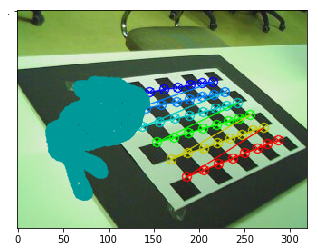

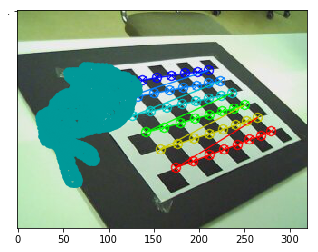

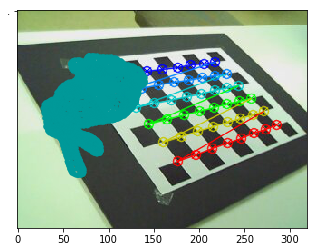

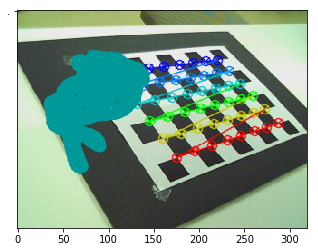

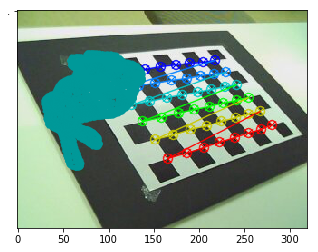

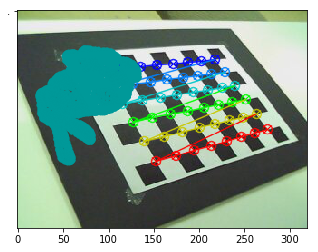

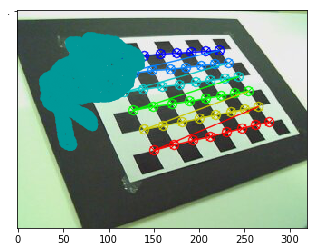

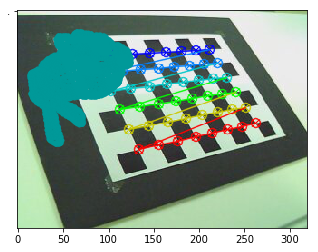

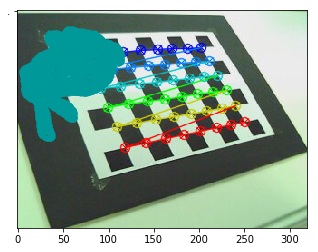

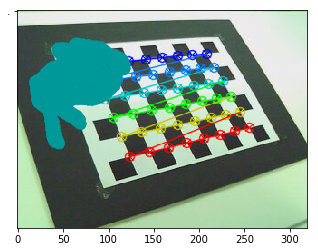

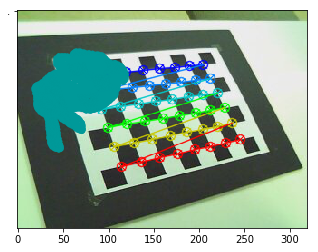

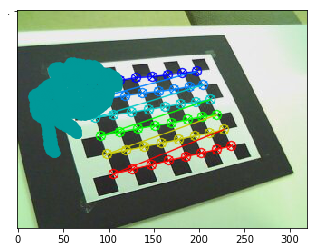

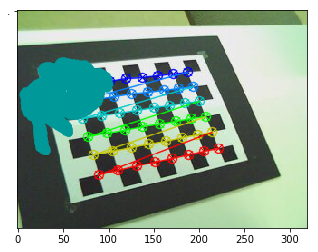

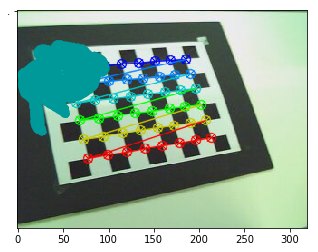

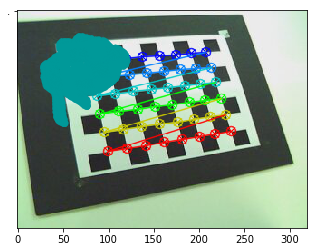

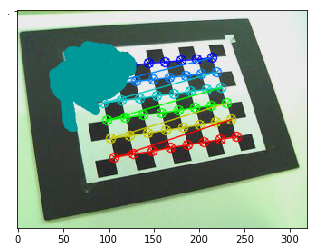

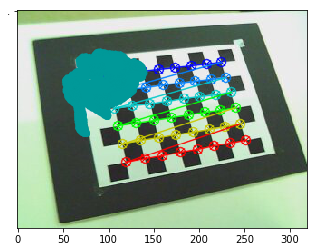

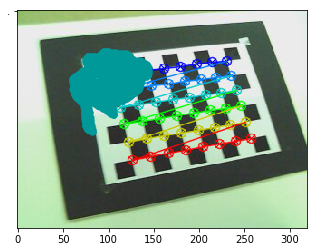

In [17]:
# Vamos a sacar las imagenes que tengan bordes detectables
valid_imgs =  []

# Cargamos las imagenes
AR_filenames = list(sorted(glob.glob("left/*.jpg")))
AR_imgs = load_images(AR_filenames)
# Sacamos las esquinas de cada imagen         
AR_corners = [cv2.findChessboardCorners(i, (8,6)) for i in AR_imgs]
# Para cada imagen comprobamos si conseguimos sacar esquinas validas y en ese caso
# dibujamos las esquinas, guardamos la imagen como valida y lo guardamos la esquina como esquina valida
AR_valid_corners = []
for img, cor in zip(AR_imgs, AR_corners):
    if cor[0] == 1:
        cv2.drawChessboardCorners(img, (8,6), cor[1], cor[0])
        valid_imgs.append(img)
        AR_valid_corners.append(cor[1])

AR_num_valid_images = len(valid_corners)
# Sacamos los puntos que deberían de ser en el sistema de referencia de la escena
AR_real_points = get_chessboard_points((8, 6), 30, 30)
# Pasamos las listas a arrays
AR_object_points = np.asarray([AR_real_points for i in range(AR_num_valid_images)], dtype=np.float32)
AR_image_points = np.asarray(AR_valid_corners, dtype=np.float32)
# Calibramos
AR_rms, AR_intrinsics, AR_dist_coeffs, AR_rvecs, AR_tvecs = cv2.calibrateCamera(AR_object_points, AR_image_points, AR_imgs[1].shape[0:2], None, None, flags=cv2.CALIB_FIX_ASPECT_RATIO)
# Pintamos el conejito en nuestras imagenes
play_ar(AR_intrinsics, AR_rvecs, AR_tvecs, valid_imgs, bunny.vertices)

**Ejercicio 9.** Transforma el modelo anterior para que se represente en
el centro de la plantilla de calibración y rotado 90 grados sobre el eje vertical del modelo. 
Ejecuta la función ``play_ar``con el nuevo modelo.

In [18]:
"""new_vertices = ... TODO ...

play_ar(intrinsics, rvecs, tvecs, valid_imgs, new_vertices)"""

'new_vertices = ... TODO ...\n\nplay_ar(intrinsics, rvecs, tvecs, valid_imgs, new_vertices)'

## 3. Par de cámaras

**Ejercicio 10.** Siguiendo el procedimiento de la primera parte
de la práctica, calibra la cámara derecha usando la secuencia
de imágenes del directorio ``right``.

/home/vision/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


Corners standard intrinsics:
 [[433.95336244   0.         144.53659782]
 [  0.         433.95336244 133.23093006]
 [  0.           0.           1.        ]]
Corners standerd dist_coefs:
 [[-0.13244554 -0.18997583  0.00688188 -0.00837019  1.66809272]]
rms standard:
 0.20517914482218738
Extrinsc:
 [array([[ 7.17363608e-01,  6.12671943e-01, -3.31696464e-01,
        -8.88585546e+01],
       [-1.70878811e-01,  6.16281546e-01,  7.68763610e-01,
        -3.14930983e+01],
       [ 6.75418304e-01, -4.94803140e-01,  5.46790607e-01,
         5.28425448e+02]]), array([[ 7.20208210e-01,  5.98020029e-01, -3.51670556e-01,
        -1.15342586e+02],
       [-1.79845345e-01,  6.50515320e-01,  7.37892587e-01,
        -4.13121022e+01],
       [ 6.70041631e-01, -4.68189986e-01,  5.76057593e-01,
         5.20247224e+02]]), array([[ 7.29912589e-01,  5.79951997e-01, -3.61777963e-01,
        -1.26724711e+02],
       [-1.91859560e-01,  6.81821239e-01,  7.05910551e-01,
        -5.65366828e+01],
       [ 6.5606213

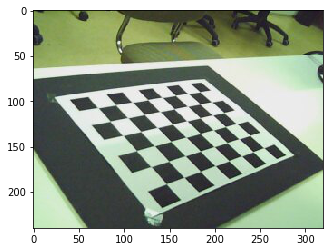

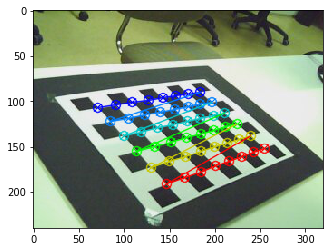

In [19]:
# Sacamos las imagenes de la derecha
filenamesRight = list(sorted(glob.glob("right/*.jpg")))
imgsRight = load_images(filenamesRight)

# Sacamos las esquinas de las imagenes de la derecha
cornersRight = [cv2.findChessboardCorners(i, (8,6)) for i in imgsRight]
# Las copiamos, ya que las operaciones que vamos a realizar van a ser destructivas
cornersRight2 = copy.deepcopy(cornersRight)
# Copiamos tambien las imagenes, por lo mismo
imgsRight2 = copy.deepcopy(imgsRight)

""" Opcional, vamos a dibujar, ya que tenemos las esquinas, los puntos en la imagen"""
# Dibujamos en cada imagen las esquinas
[cv2.drawChessboardCorners(img, (8,6), cor[1], cor[0]) for img, cor in zip(imgsRight2, cornersRight) if cor[0]]

# Imprimimos las imagenes
plt.figure()
plt.imshow(imgsRight[0])
plt.figure()
plt.imshow(imgsRight2[0])

# Sacamos las esquinas validas de las que hemos calculado
valid_corners_r = [cor[1] for cor in cornersRight if cor[0]]
num_valid_images_r = len(valid_corners_r)

# Matriz 30x3 con las coordenadas de los puntos de las esquinas
real_points_r = get_chessboard_points((8, 6), 30, 30)
# Convertimos nuestra lista de puntos en el sistema de referencia de la escena en un array
object_points_r = np.asarray([real_points_r for i in range(num_valid_images)], dtype=np.float32)
# Convertimos nuestra lista de esquinas validas en un array
image_points_r = np.asarray(valid_corners_r, dtype=np.float32)

# Calibramos
rms_r, intrinsics_r, dist_coeffs_r, rvecs_r, tvecs_r = cv2.calibrateCamera(object_points_r, image_points_r, imgsRight[1].shape[0:2], None, None, flags=cv2.CALIB_FIX_ASPECT_RATIO)

print("Corners standard intrinsics:\n",intrinsics_r)
print("Corners standerd dist_coefs:\n", dist_coeffs_r)
print("rms standard:\n", rms_r)

# Calculamos los extrinsecos con Rodrigues pasandole los vectores de rotacion y le añadimos los vectores de traslaccion
extrinsics_r = list(map(lambda rvec_r, tvec_r: np.hstack((cv2.Rodrigues(rvec_r)[0], tvec_r)), rvecs_r, tvecs_r))
print("Extrinsc:\n",extrinsics_r)


**Ejercicio 11.** ¿Cuál es la distancia, en milímetros, entre las dos cámaras?

Sugerencia: Utiliza los extrínsecos del primer par de imágenes el que simultáneamente se vean todos los puntos de la plantilla.


In [20]:
rotM_r = cv2.Rodrigues(rvecs_r[0])[0]
cameraPosition_r = -np.matrix(rotM_r).T * np.matrix(tvecs_r[0])
pp(cameraPosition_r)
rotM = cv2.Rodrigues(rvecs[0])[0]
cameraPosition = -np.matrix(rotM).T * np.matrix(tvecs[0])
pp(cameraPosition)

dist = np.linalg.norm(cameraPosition_r - cameraPosition)
pp(dist)

matrix([[-298.54582962],
        [ 335.31632914],
        [-294.20139157]])
matrix([[-308.89687809],
        [ 298.78607668],
        [-283.88298702]])
39.34555911129915


# Fuente ejercicio 11
La información para calcular la distancia entre cámaras, la hemos obtenido utilizando los datos del enlace:

https://stackoverflow.com/questions/14444433/calculate-camera-world-position-with-opencv-python

